# Retrosynthesis using GNNs with Attention

Retrosynthesis is one of the most important techniques in Organic Chemistry, offering a "backward" approach in Organic Synthesis, with prevalent applications in the field of Drug Discovery and Drug Development. While the final goal of Organic Synthesis is Synthesis itself, Retrosynthesis is crucial in finding highly available and / or high quality pathways to achieve it, deconstructing known product molecules into sets of possible precursors. Historically an extremely complex and time-intensive task that is heavily reliant on prior domain knowledge and expertise (known reactions and compounds in the 10<sup>7</sup>s), Deep Learning can be used to immensely benefit it by "quickly" offering pathway predictions to be later reviewed by the actual experts, vastly accelerating the process. In this context and that of Deep Learning, our Assignment aims to offer a trivial implementation of the first steps of Retrosynthesis pipeline, building a model for Chemical Reaction Center prediction i.e. for finding which of the product's bonds can be broken, with the aim of splitting it into valid predecessors.

### Dataset
Our model is trained and tested on USPTO-50k (United States Patent and Trademark Office), a widely recognized dataset in ML assisted Organic Synthesis that consists of 50K extracted atom-mapped reactions in the form of SMILES (Simplified Molecular Input Line Entry System) strings.

## Imports

In [ ]:
from __future__ import annotations

import csv, os, re
from pathlib import Path
from typing import Tuple, Sequence

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import TransformerConv, global_mean_pool

from rdkit import Chem
from rdkit.Chem import rdChemReactions
from joblib import Parallel, delayed
import tqdm.auto as tqdm

## Feature Extraction Utils

In [13]:
_SYMBOLS = [
    'C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br', 'Li', 'Na', 'K',
    'Mg', 'B', 'Sn', 'I', 'Se', 'unk'
]
_SYMBOL_TO_IDX = {s: i for i, s in enumerate(_SYMBOLS)}
_BOND_TYPES = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
    Chem.rdchem.BondType.AROMATIC,
]
_BOND_TO_IDX = {b: i for i, b in enumerate(_BOND_TYPES)}


def _one_hot(idx: int, dim: int) -> torch.Tensor:
    v = torch.zeros(dim); v[idx] = 1.0; return v


def atom_features(a: Chem.Atom) -> torch.Tensor:
    return torch.cat([
        _one_hot(_SYMBOL_TO_IDX.get(a.GetSymbol(), _SYMBOL_TO_IDX['unk']), len(_SYMBOLS)),
        torch.tensor([
            a.GetFormalCharge(), a.GetTotalDegree(), a.GetTotalNumHs(),
            a.GetTotalValence(), float(a.GetIsAromatic()), float(a.IsInRing())
        ])
    ])


def bond_features(b: Chem.Bond) -> torch.Tensor:
    return torch.cat([
        _one_hot(_BOND_TO_IDX[b.GetBondType()], len(_BOND_TYPES)),
        torch.tensor([float(b.GetIsConjugated()), float(b.IsInRing())])
    ])

## Graph Conversion Utilities

In [14]:
def _bonds_to_break(rcts: Sequence[Chem.Mol], prod: Chem.Mol):
    r, p = set(), set()
    for m in rcts:
        for b in m.GetBonds():
            a1, a2 = b.GetBeginAtom().GetAtomMapNum(), b.GetEndAtom().GetAtomMapNum()
            if a1 and a2: r.add(tuple(sorted((a1, a2))))
    for b in prod.GetBonds():
        a1, a2 = b.GetBeginAtom().GetAtomMapNum(), b.GetEndAtom().GetAtomMapNum()
        if a1 and a2: p.add(tuple(sorted((a1, a2))))
    return p - r


def _pair_to_graph(pair: Tuple[Sequence[Chem.Mol], Chem.Mol]):
    rcts, prod = pair
    x = torch.stack([atom_features(at) for at in prod.GetAtoms()])

    # mapping for fast lookup (skip mapNum == 0)
    map2idx = {a.GetAtomMapNum(): a.GetIdx() for a in prod.GetAtoms() if a.GetAtomMapNum()}
    break_idx = {tuple(sorted((map2idx[m1], map2idx[m2]))) for m1, m2 in _bonds_to_break(rcts, prod) if m1 in map2idx and m2 in map2idx}

    ei, ea, el = [], [], []
    for b in prod.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        feat = bond_features(b)
        lbl = 1 if tuple(sorted((i, j))) in break_idx else 0
        for u, v in ((i, j), (j, i)):
            ei.append([u, v]); ea.append(feat); el.append(lbl)

    return Data(
        x=x,
        edge_index=torch.tensor(ei, dtype=torch.long).t().contiguous(),
        edge_attr=torch.stack(ea),
        y=torch.tensor(el, dtype=torch.float).view(-1, 1)
    )


## Data parsing function

In [15]:
def _row_to_pair(row):
    """Convert a CSV row to (reactant mols, product mol) or return None."""
    try:
        left, right = row['rxnSmiles_Mapping_NameRxn'].split('>>')
        idx = [int(i) for i in re.findall(r'\d+', row['reactantSet_NameRxn'])]
        rcts = [left.split('.')[i] for i in idx]
        prods = right.split('.')
        if len(prods) != 1:
            return None
        r_mols = [Chem.MolFromSmiles(s) for s in rcts]
        p_mol = Chem.MolFromSmiles(prods[0])
        rxn = rdChemReactions.ChemicalReaction(); [rxn.AddReactantTemplate(m) for m in r_mols]; rxn.AddProductTemplate(p_mol)
        if rxn.Validate()[1]:
            return None
        return r_mols, p_mol
    except Exception:
        return None

## Dataset Class

In [ ]:
class CentreDataset(InMemoryDataset):
    def __init__(self, csv_path: str, jobs: int):
        self.csv_path, self.jobs = csv_path, jobs
        super().__init__(root=Path(csv_path).parent)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def processed_file_names(self):
        return ["centre_data.pt"]

    # ----- heavy I/O and RDKit in parallel -----
    def _parse_pairs(self):
        rows = list(csv.DictReader(open(self.csv_path)))
        print(f"CSV rows: {len(rows)} — RDKit parsing on {self.jobs} processes …")
        pairs = Parallel(n_jobs=self.jobs)(delayed(_row_to_pair)(r) for r in rows)
        return [p for p in pairs if p]

    def process(self):
        pairs = self._parse_pairs()
        print(f"Mol-pairs: {len(pairs)} — graph build on {self.jobs} threads …")
        graphs = Parallel(n_jobs=self.jobs, backend="multiprocessing", batch_size=128)(
            delayed(_pair_to_graph)(p) for p in tqdm.tqdm(pairs, desc="graphs")
        )
        pos = sum(int(g.y.sum()) for g in graphs)
        tot = sum(int(g.y.numel()) for g in graphs)
        print(f"Positive edge ratio = {pos/tot:.2%}")
        data, slices = self.collate(graphs)
        Path(self.processed_dir).mkdir(parents=True, exist_ok=True)
        torch.save((data, slices), self.processed_paths[0])

## Model

In [17]:
class Encoder(nn.Module):
    def __init__(self, node_dim: int, edge_dim: int, hidden: int = 128):
        super().__init__()
        self.t1 = TransformerConv(node_dim, hidden // 8, heads=8, edge_dim=edge_dim)
        self.t2 = TransformerConv(hidden, hidden, concat=False, edge_dim=edge_dim)
    def forward(self, x, ei, ea):
        return self.t2(F.leaky_relu(self.t1(x, ei, ea)), ei, ea)

class LinkClassifier(nn.Module):
    def __init__(self, node_dim: int, edge_dim: int):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(node_dim * 3 + edge_dim, 128), nn.ReLU(), nn.Linear(128, 1))
    def forward(self, h, ei, ea, batch):
        s, t = ei
        g = global_mean_pool(h, batch)[batch[s]]
        return self.mlp(torch.cat([h[s], h[t], ea, g], dim=-1))

class GNN(nn.Module):
    def __init__(self, node_dim: int, edge_dim: int, hidden: int = 128):
        super().__init__()
        self.enc = Encoder(node_dim, edge_dim, hidden)
        self.cls = LinkClassifier(hidden, edge_dim)
    def forward(self, data: Data):
        h = self.enc(data.x, data.edge_index, data.edge_attr)
        return self.cls(h, data.edge_index, data.edge_attr, data.batch)

## Evaluation Utils

In [18]:
def _collect_preds(model, loader, device="cpu"):
    model.eval()
    probs, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logit = model(batch)
            mask = batch.edge_index[0] < batch.edge_index[1]  # undirected collapse
            probs.append(torch.sigmoid(logit[mask]).cpu())
            labels.append(batch.y[mask].cpu())
    return torch.cat(probs), torch.cat(labels)

def _roc_auc(y_true: torch.Tensor, y_prob: torch.Tensor) -> float:
    from sklearn.metrics import roc_auc_score
    y_numpy, p_numpy = y_true.numpy(), y_prob.numpy()
    if y_numpy.sum() in (0, len(y_numpy)):
        return 0.0
    return float(roc_auc_score(y_numpy, p_numpy))


## Training Utils

In [19]:
def _run_epoch(model, loader, criterion, opt=None, device="cpu"):
    train = opt is not None
    model.train() if train else model.eval()
    tot_loss, preds, labels = 0.0, [], []
    with torch.set_grad_enabled(train):
        for batch in loader:
            batch = batch.to(device)
            logit = model(batch)
            loss = criterion(logit, batch.y)
            if train:
                opt.zero_grad(); loss.backward(); opt.step()
            else:
                # collapse undirected duplicates for metrics
                mask = batch.edge_index[0] < batch.edge_index[1]
                preds.append(torch.sigmoid(logit[mask]).cpu())
                labels.append(batch.y[mask].cpu())
            tot_loss += loss.item() * batch.num_graphs
    if train:
        return tot_loss / len(loader.dataset)
    else:
        if labels:
            p = torch.cat(preds); l = torch.cat(labels)
            return tot_loss / len(loader.dataset), _roc_auc(l, p)
        return tot_loss / len(loader.dataset), 0.0

## Training

In [27]:
EPOCHS = 25

device = "cuda" if torch.cuda.is_available() else "cpu"
ds = CentreDataset('data/dataSetB.csv', os.cpu_count())

n_tr, n_val = int(0.8 * len(ds)), int(0.1 * len(ds))
# train_ds, val_ds, test_ds = torch.utils.data.(ds, [n_tr, n_val, len(ds) - n_tr - n_val])

train_size = int(0.8 * len(ds))
val_size = int(0.1 * len(ds))
test_size = len(ds) - train_size - val_size

train_ds = ds[:train_size]
val_ds = ds[train_size : train_size + val_size]
test_ds = ds[train_size + val_size :]

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

hidden = 128
model = GNN(ds.num_node_features, ds.num_edge_features, hidden=hidden).to(device)

pos = sum(int(d.y.sum()) for d in ds)
neg = sum(int(d.y.numel() - d.y.sum()) for d in ds)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([neg/pos], device=device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

best_auc = 0.0
for epoch in tqdm.tqdm(range(1, EPOCHS + 1)):
    tr_loss = _run_epoch(model, train_loader, criterion, opt=optimizer, device=device)
    val_loss, val_auc = _run_epoch(model, val_loader, criterion, device=device)
    print(f"Ep{epoch:02d}: train {tr_loss:.4f}  val {val_loss:.4f}  AUC {val_auc:.3f}")
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), "best_model.pt")

  4%|▍         | 1/25 [00:17<06:50, 17.11s/it]

Ep01: train 1.0810  val 0.8774  AUC 0.877


  8%|▊         | 2/25 [00:29<05:28, 14.30s/it]

Ep02: train 0.8060  val 0.7355  AUC 0.915


 12%|█▏        | 3/25 [00:42<05:00, 13.68s/it]

Ep03: train 0.7194  val 0.6795  AUC 0.925


 16%|█▌        | 4/25 [00:54<04:36, 13.18s/it]

Ep04: train 0.6787  val 0.6483  AUC 0.931


 20%|██        | 5/25 [01:07<04:21, 13.05s/it]

Ep05: train 0.6534  val 0.6261  AUC 0.935


 24%|██▍       | 6/25 [01:18<03:55, 12.37s/it]

Ep06: train 0.6329  val 0.6081  AUC 0.938


 28%|██▊       | 7/25 [01:31<03:46, 12.60s/it]

Ep07: train 0.6162  val 0.5935  AUC 0.941


 32%|███▏      | 8/25 [01:42<03:23, 11.99s/it]

Ep08: train 0.6023  val 0.5812  AUC 0.943


 36%|███▌      | 9/25 [01:55<03:16, 12.30s/it]

Ep09: train 0.5899  val 0.5717  AUC 0.945


 40%|████      | 10/25 [02:07<03:04, 12.33s/it]

Ep10: train 0.5801  val 0.5636  AUC 0.946


 44%|████▍     | 11/25 [02:20<02:52, 12.30s/it]

Ep11: train 0.5710  val 0.5543  AUC 0.947


 48%|████▊     | 12/25 [02:32<02:42, 12.50s/it]

Ep12: train 0.5635  val 0.5474  AUC 0.949


 52%|█████▏    | 13/25 [02:45<02:31, 12.64s/it]

Ep13: train 0.5567  val 0.5428  AUC 0.950


 56%|█████▌    | 14/25 [02:58<02:18, 12.62s/it]

Ep14: train 0.5497  val 0.5358  AUC 0.951


 60%|██████    | 15/25 [03:11<02:05, 12.59s/it]

Ep15: train 0.5447  val 0.5301  AUC 0.951


 64%|██████▍   | 16/25 [03:23<01:53, 12.62s/it]

Ep16: train 0.5390  val 0.5260  AUC 0.952


 68%|██████▊   | 17/25 [03:36<01:40, 12.56s/it]

Ep17: train 0.5346  val 0.5207  AUC 0.953


 72%|███████▏  | 18/25 [03:48<01:27, 12.50s/it]

Ep18: train 0.5290  val 0.5182  AUC 0.954


 76%|███████▌  | 19/25 [04:01<01:15, 12.62s/it]

Ep19: train 0.5248  val 0.5122  AUC 0.954


 80%|████████  | 20/25 [04:14<01:03, 12.61s/it]

Ep20: train 0.5212  val 0.5101  AUC 0.955


 84%|████████▍ | 21/25 [04:26<00:50, 12.72s/it]

Ep21: train 0.5170  val 0.5046  AUC 0.955


 88%|████████▊ | 22/25 [04:40<00:38, 12.84s/it]

Ep22: train 0.5140  val 0.5030  AUC 0.956


 92%|█████████▏| 23/25 [04:52<00:25, 12.80s/it]

Ep23: train 0.5103  val 0.4984  AUC 0.956


 96%|█████████▌| 24/25 [05:05<00:12, 12.78s/it]

Ep24: train 0.5073  val 0.4961  AUC 0.957


100%|██████████| 25/25 [05:18<00:00, 12.73s/it]

Ep25: train 0.5045  val 0.4947  AUC 0.957


## Evaluation

Test AUC = 0.957

Precision / recall / F1 on test bonds:
              precision    recall  f1-score   support

         0.0      0.998     0.869     0.929    131076
         1.0      0.163     0.927     0.278      3605

    accuracy                          0.871    134681
   macro avg      0.580     0.898     0.603    134681
weighted avg      0.975     0.871     0.912    134681



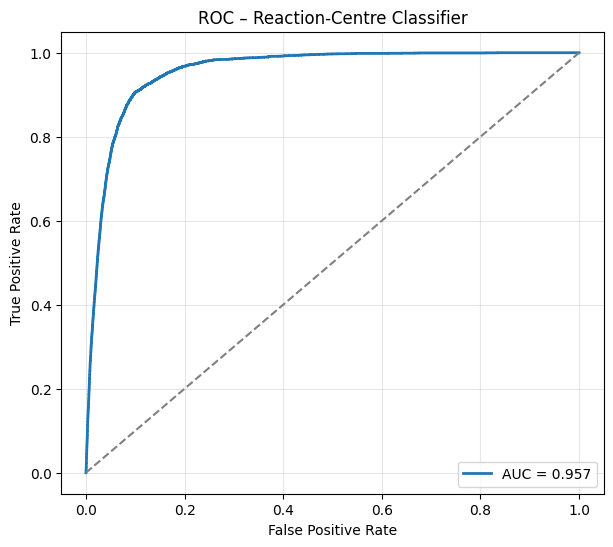

In [34]:
# model = GNN(ds.num_node_features, ds.num_edge_features, hidden=hidden).to(device)
# model.load_state_dict(torch.load("best_model_best.pt"))
_, test_auc = _run_epoch(model, test_loader, criterion, device=device)
print(f"Test AUC = {test_auc:.3f}")


import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve
probs, y_true = _collect_preds(model, test_loader, device)
y_pred = (probs > 0.5).int()  # threshold can be tuned

print("\nPrecision / recall / F1 on test bonds:")
print(classification_report(y_true.numpy(), y_pred.numpy(), digits=3))

fpr, tpr, _ = roc_curve(y_true.numpy(), probs.numpy())
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {test_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="grey")
plt.xlabel("False Positive Rate");  plt.ylabel("True Positive Rate")
plt.title("ROC – Reaction-Centre Classifier");  plt.legend();  plt.grid(alpha=.3)
plt.show()